In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

train1 = pd.read_csv('train_1.csv', sep=',', header=0)
train2 = pd.read_csv('train_2.csv', sep=',', header=0)
train3 = pd.read_csv('train_3.csv', sep=',', header=0)
train4 = pd.read_csv('train_4.csv', sep=',', header=0)
train = pd.concat([train1, train2, train3, train4], ignore_index=True)
train = train[train['store_nbr'] == 1]

In [2]:
train = train.drop(columns=["id", "store_nbr"], axis=1)
train_data = train.pivot_table(index=['date'], columns="family", values='sales')
train_data["total_sales"] = train_data[list(train_data.columns[1:])].sum(axis=1)
train_data.to_csv('test_out.csv')

data = pd.read_csv('test_out.csv', sep=',', header=0)

In [3]:
sc = MinMaxScaler(feature_range=(0,1))

def transform_data(train_data, family):
    train = train_data.iloc[:1300, family].values

    train = np.array(train)
    train = train.reshape(-1,1)

    train_scaled = sc.fit_transform(train)

    train_x = []
    train_y = []

    for i in range(7,1300):
        train_x.append(train_scaled[i-7:i, 0])
        train_y.append(train_scaled[i,0])

    train_x, train_y = np.array(train_x), np.array(train_y)
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))

    return train_x, train_y


In [4]:
def train_model(train_x, train_y, num_lstm_units, num_epochs, batch_size):
    model = Sequential()

    model.add(LSTM(units=num_lstm_units, return_sequences=True, input_shape = (train_x.shape[1], 1)))

    model.add(LSTM(units=num_lstm_units, return_sequences=True))

    model.add(LSTM(units=num_lstm_units, return_sequences=True))

    model.add(LSTM(units=num_lstm_units))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='msle')

    model.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_size)

    return model


In [5]:
def test(test_data, family, model):
    test = test_data.iloc[1300:, family].values

    test = np.array(test)
    test = test.reshape(-1,1)
    test_scaled = sc.transform(test)

    test_x = []
    for i in range(7, 385):
        test_x.append(test_scaled[i-7:i,0])

    test_x = np.array(test_x)
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1],1))

    pred = model.predict(test_x)
    pred = sc.inverse_transform(pred)
    len(test_x), len(test)

    return test, pred 

In [6]:
train_x, train_y = transform_data(data, -1)
model = train_model(train_x, train_y, 60, 150, 7)
test, pred = test(data, -1, model)

Epoch 1/150
185/185 [==============================] - 5s 5ms/step - loss: 0.0227
Epoch 2/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0067
Epoch 3/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0064
Epoch 4/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0064
Epoch 5/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0063
Epoch 6/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0061
Epoch 7/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0059
Epoch 8/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0057
Epoch 9/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0057
Epoch 10/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0056
Epoch 11/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0056
Epoch 12/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0054
Epoch 13/150


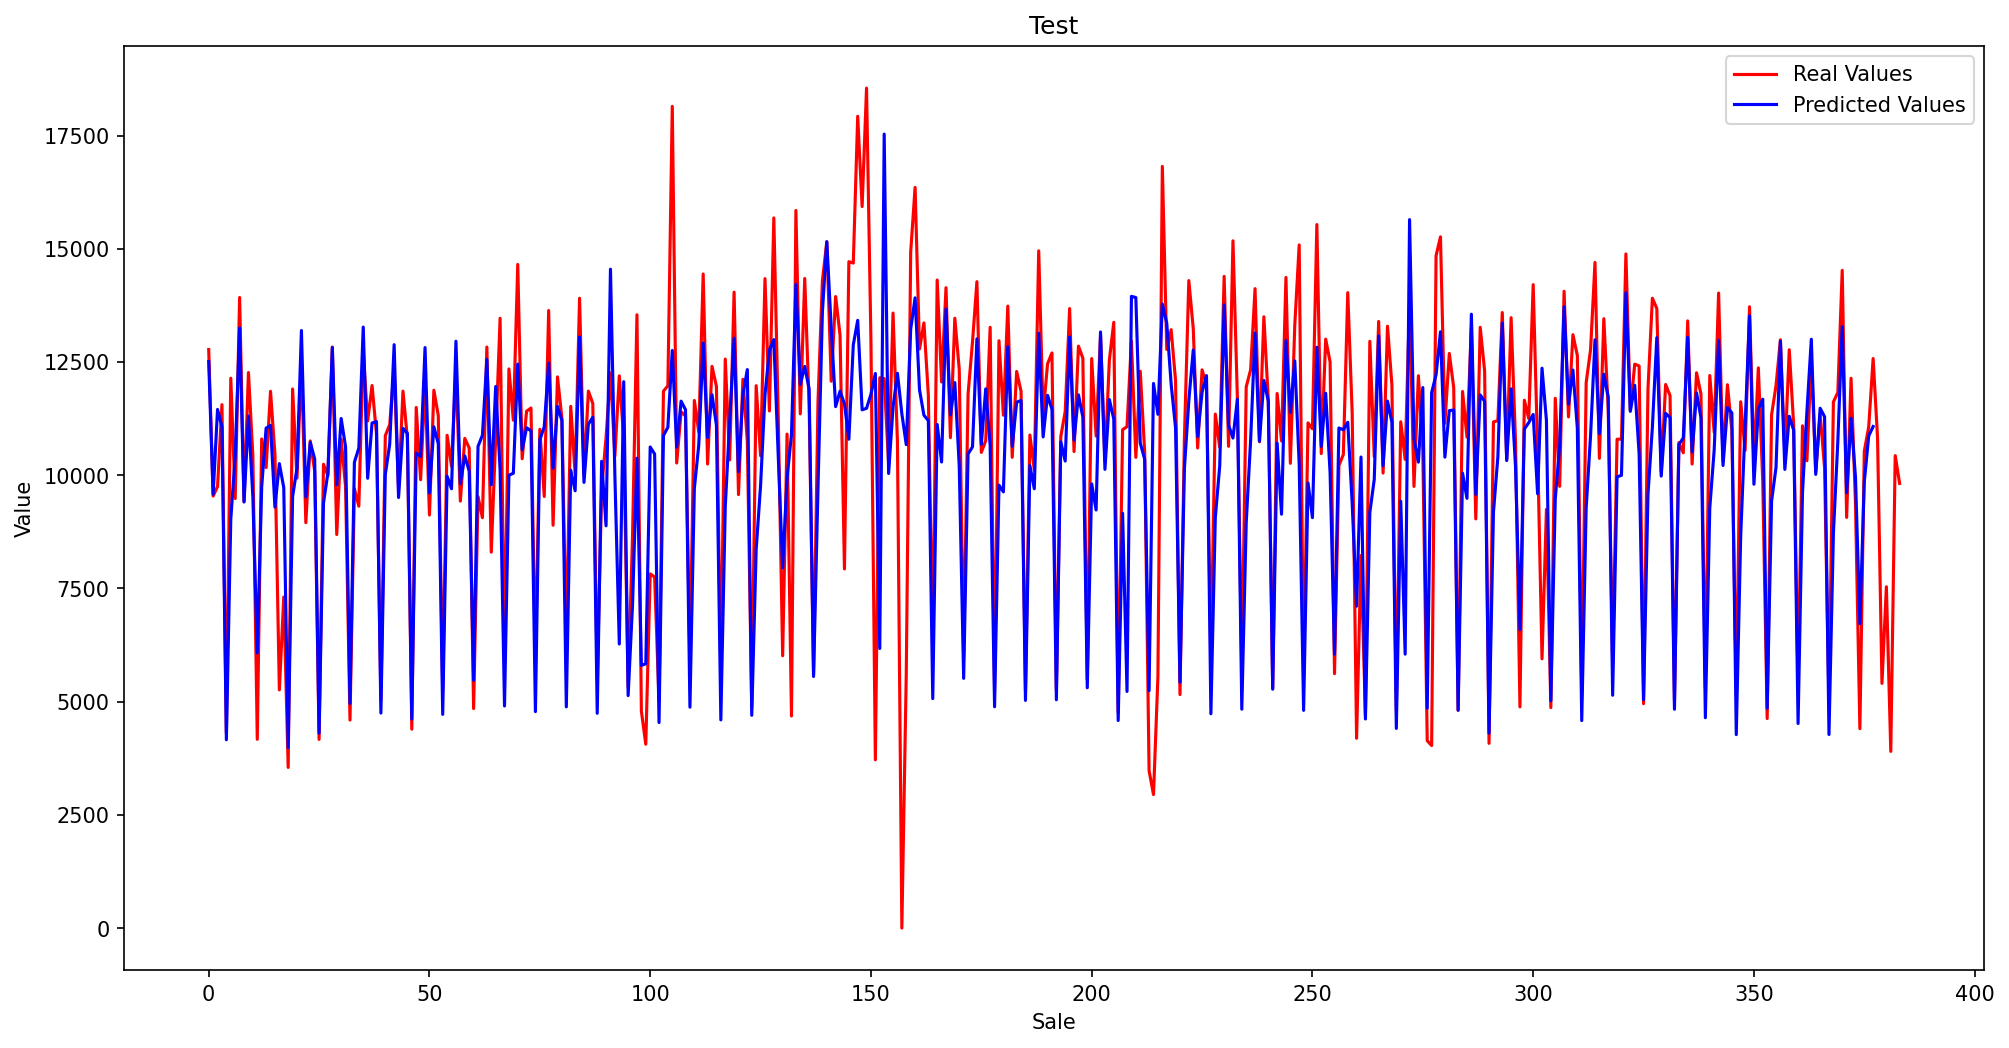

In [7]:
plt.figure(figsize=(16,8), dpi=150)
plt.plot(test, color='red', label='Real Values')
plt.plot(pred, color='blue', label='Predicted Values')
plt.title('Test')
plt.xlabel('Sale')
plt.ylabel('Value')
plt.legend()
plt.show()